<a href="https://colab.research.google.com/github/mashaan14/YouTube-channel/blob/main/notebooks/2024_06_24_neighbor_sampler.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GNN Neighbor Sampler in JAX

## YouTube:
I explained this notebook in a [YouTube video](https://youtu.be/YQwUlmUkJuI).

## Acknowledgment:
I borrowed some code from [Introduction to Graph Neural Nets with JAX/jraph](https://colab.research.google.com/github/deepmind/educational/blob/master/colabs/summer_schools/intro_to_graph_nets_tutorial_with_jraph.ipynb#scrollTo=1n1kCuqtkvfm) and [pytorch-geometric tutorials](https://pytorch-geometric.readthedocs.io/en/latest/get_started/colabs.html).

## References:
```bibtex
@software{jraph2020github,
  author = {Jonathan Godwin* and Thomas Keck* and Peter Battaglia and Victor Bapst and Thomas Kipf and Yujia Li and Kimberly Stachenfeld and Petar Veli\v{c}kovi\'{c} and Alvaro Sanchez-Gonzalez},
  title = {{J}raph: {A} library for graph neural networks in jax.},
  url = {http://github.com/deepmind/jraph},
  version = {0.0.1.dev},
  year = {2020},
}
```

```bibtex
@inproceedings{Fey/Lenssen/2019,
  title={Fast Graph Representation Learning with {PyTorch Geometric}},
  author={Fey, Matthias and Lenssen, Jan E.},
  booktitle={ICLR Workshop on Representation Learning on Graphs and Manifolds},
  year={2019},
}
```

## Graph Representation

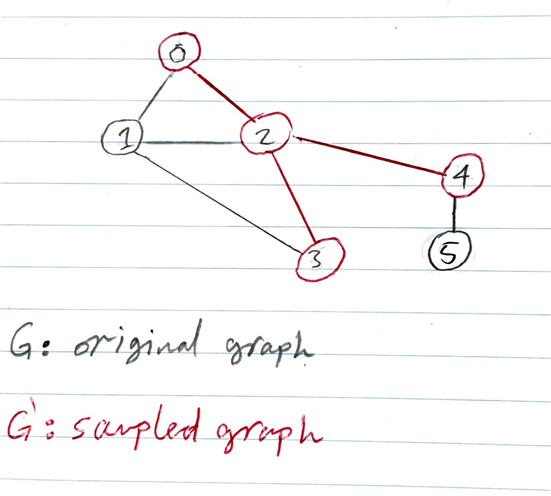

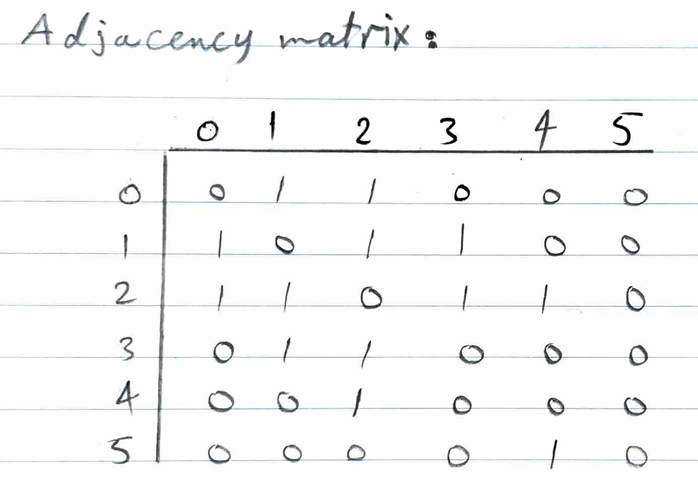

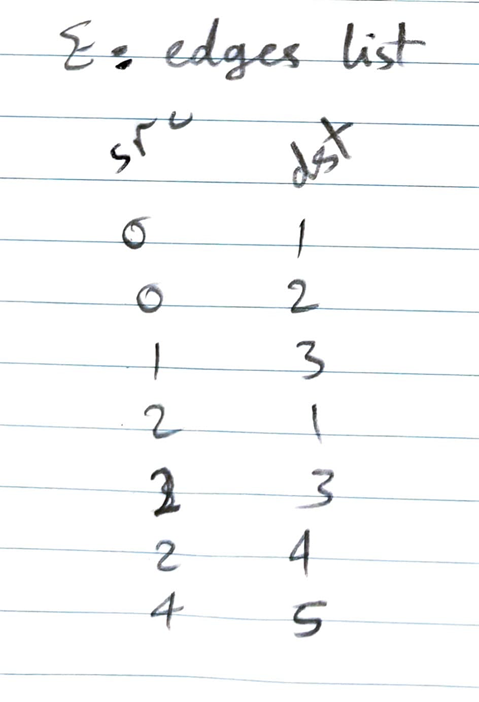

## Sparse Matrices

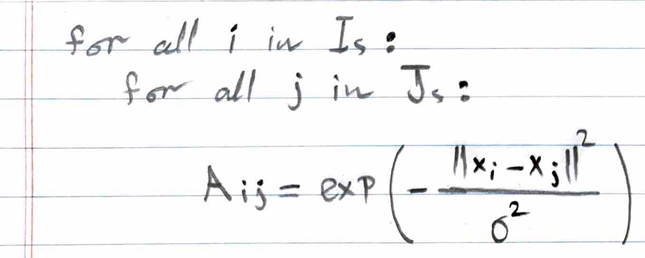

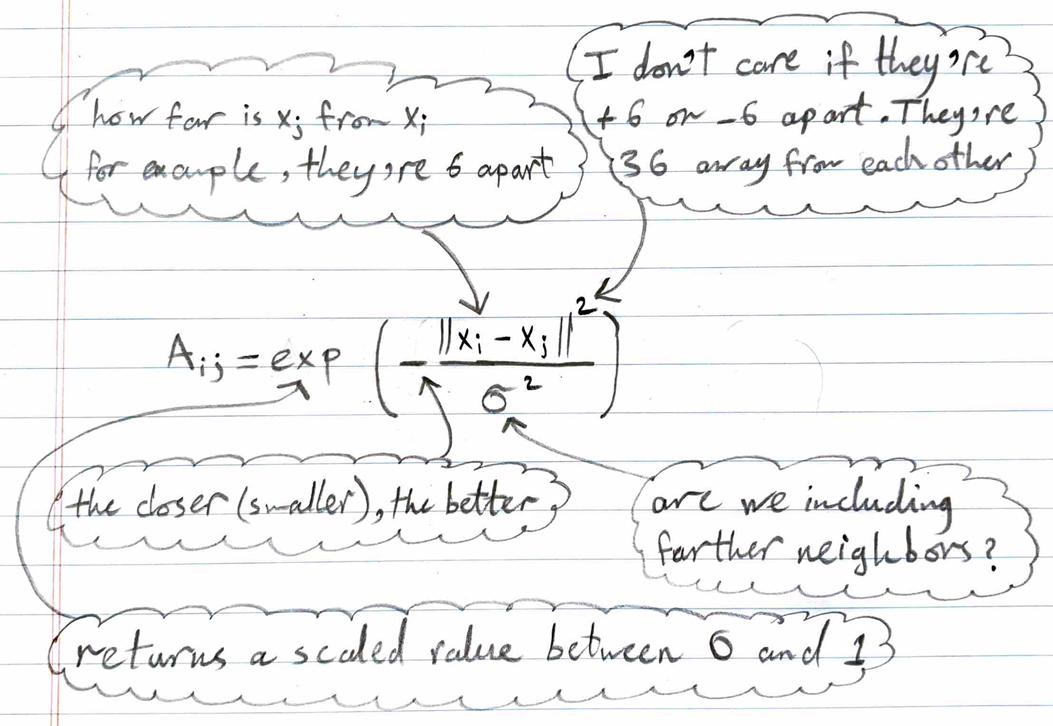

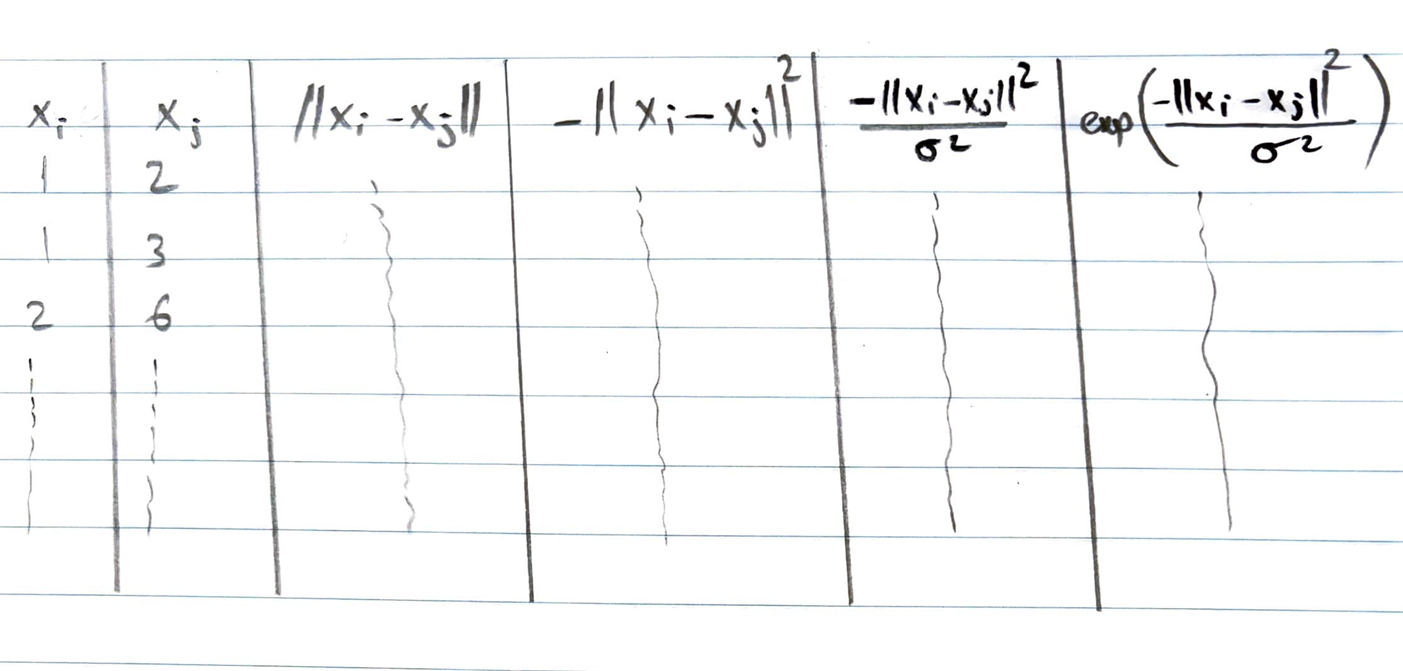

## Import libraries

In [ ]:
# install pytorch_geometric
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# install jraph
!pip install git+https://github.com/deepmind/jraph.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/deepmind/jraph.git to /tmp/pip-req-build-g77bmmw0
  Running command git clone --filter=blob:none --quiet https://github.com/deepmind/jraph.git /tmp/pip-req-build-g77bmmw0
  Resolved https://github.com/deepmind/jraph.git to commit 51f5990104f7374492f8f3ea1cbc47feb411c69c
  Preparing metadata (setup.py) ... done


In [ ]:
# Standard libraries
import numpy as np
import scipy as sp
import seaborn as sns
import pandas as pd
import random
from typing import Any, NamedTuple, Iterable, Mapping, Union, Optional
from more_itertools import chunked # import chunked from more_itertools


# Plotting libraries
import matplotlib
import matplotlib.pyplot as plt
import networkx as nx
from IPython.display import Javascript  # Restrict height of output cell.

# jax
import jax
import jax.numpy as jnp
import jax.tree_util as tree
import flax
import flax.linen as nn
from flax.training import train_state
import optax
import pickle

# jraph
import jraph
from jraph._src import models as jraph_models

# PyTorch geometric
import torch_geometric
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

In [ ]:
random_seed = 42
random.seed(random_seed)
key = jax.random.PRNGKey(random_seed)
torch_geometric.seed_everything(random_seed)
plt.style.use('dark_background')
accuracy_list = []

## Create A Toy Graph

In [ ]:
edges = jax.random.randint(key, (50,2), 0, 10)
edges = jnp.concatenate((edges, edges[:, [1, 0]]), axis=0)
features = jax.random.uniform(key, shape=(10,2))

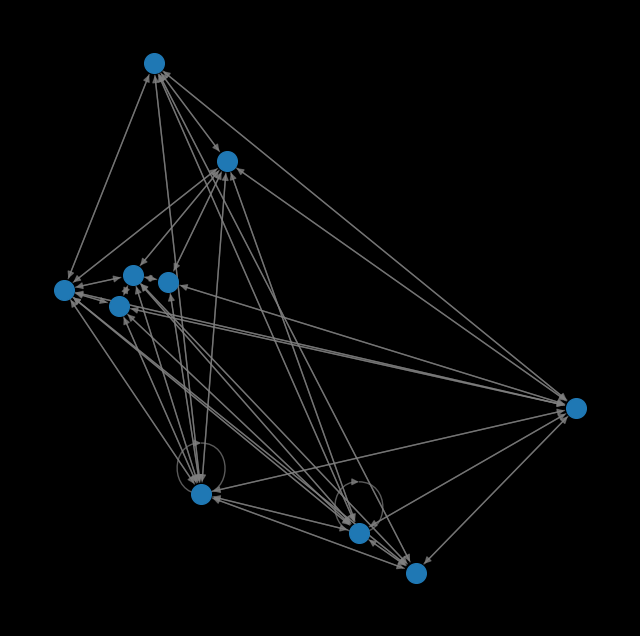

In [ ]:
A = sp.sparse.csr_array((jnp.ones((edges.shape[0],1)).squeeze(), (edges[:,0], edges[:,1])), shape=(10, 10))
G = nx.from_scipy_sparse_array(A, create_using=nx.DiGraph)
node_pos=features
plt.figure(figsize=(8,8))
plt.axis('off')
nx.draw_networkx_nodes(G, pos=node_pos, node_size=200)
nx.draw_networkx_edges(G, pos=node_pos, edge_color="grey", alpha=0.7)
plt.show()

## `neighbor_sampler` Function

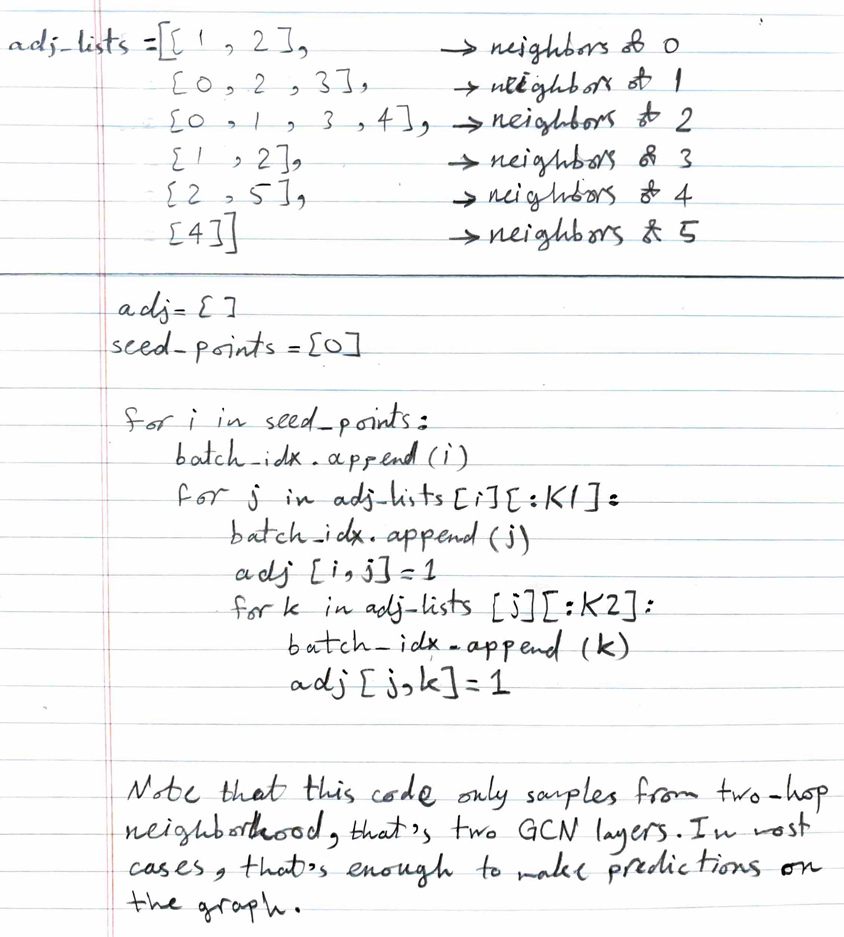

In [ ]:
GraphsInfo = NamedTuple('GraphsInfo', [('global_idx', int), ('train_mask', bool), ('val_mask', bool), ('test_mask', bool), ('y', int), ('one_hot_labels', int)])

In [ ]:
def neighbor_sampler(edges, features, graph_train_mask, graph_val_mask,
                     graph_test_mask, graph_labels, one_hot_labels,
                     seed_nodes, seed_nodes_per_subgraph, K1, K2):
  graphs_list = []
  graphinfo_list   = []

  num_all_nodes = features.shape[0]
  adj = sp.sparse.csr_matrix((np.ones((edges.shape[0]), dtype=np.float32), (edges[:, 0], edges[:, 1])), shape=(num_all_nodes, num_all_nodes))
  adj += adj.transpose()
  adj_lil = adj.tolil()

  adj_lists = [[] for _ in range(num_all_nodes)]
  for i in range(num_all_nodes):
    rows = adj_lil[i].rows[0]
    # self-edge needs to be removed for valid format of METIS
    if i in rows:
      rows.remove(i)

    random.Random(random_seed).shuffle(rows)
    adj_lists[i] = rows

  # shuffle the list of seed nodes and get batches of size (seed_nodes_per_subgraph)
  nodes_list = list(range(0,num_all_nodes))
  random.Random(random_seed).shuffle(nodes_list)
  batches = list(chunked(nodes_list, seed_nodes_per_subgraph)) # convert the generator to a list
  batch_idx = [[] for _ in range(len(batches))] # use the length of the list

  nb_row   = []
  nb_col   = []
  nb_data  = []
  for batch in batches:
    for i in batch:
      batch_idx[batches.index(batch)].append(i)
      for j in adj_lists[i][:K1]:
        batch_idx[batches.index(batch)].append(j)
        nb_row.append(i)
        nb_col.append(j)
        nb_data.append(1)
        for k in adj_lists[j][:K2]:
          batch_idx[batches.index(batch)].append(k)
          nb_row.append(j)
          nb_col.append(k)
          nb_data.append(1)

  nb_row.append(num_all_nodes - 1)
  nb_col.append(num_all_nodes - 1)
  nb_data.append(0)
  sample_adj = sp.sparse.coo_matrix((nb_data, (nb_row, nb_col)), shape=(num_all_nodes,num_all_nodes)).tocsr()

  global_idx        = []
  features_batches  = []
  adj_batches       = []
  if graph_train_mask is not None:
    graph_train_mask_batches  = []
    graph_val_mask_batches    = []
    graph_test_mask_batches   = []
    graph_labels_batches      = []
    one_hot_labels_batches    = []
  for batch in batch_idx:
    global_idx.append(batch)
    features_batches.append(features[batch,:])
    adj_batches.append(sample_adj[batch, :][:, batch])
    if graph_train_mask is not None:
      graph_train_mask_batches.append(graph_train_mask[jnp.asarray(batch, dtype=jnp.int32)])
      graph_val_mask_batches.append(graph_val_mask[jnp.asarray(batch, dtype=jnp.int32)])
      graph_test_mask_batches.append(graph_test_mask[jnp.asarray(batch, dtype=jnp.int32)])
      graph_labels_batches.append(graph_labels[jnp.asarray(batch, dtype=jnp.int32)])
      one_hot_labels_batches.append(one_hot_labels[jnp.asarray(batch, dtype=jnp.int32),:])

  for i in range(len(global_idx)):
    graph = jraph.GraphsTuple(
        n_node=jnp.asarray([features_batches[i].shape[0]]),
        n_edge=jnp.asarray([adj_batches[i].nnz]),
        nodes=features_batches[i],
        edges=None,
        globals=None,
        senders=jnp.asarray(adj_batches[i].tocoo().row),
        receivers=jnp.asarray(adj_batches[i].tocoo().col))
    graphs_list.append(graph)

    if graph_train_mask is not None:
      graphinfo = GraphsInfo(global_idx=global_idx[i],
                            train_mask=graph_train_mask_batches[i],
                            val_mask=graph_val_mask_batches[i],
                            test_mask=graph_test_mask_batches[i],
                            y=graph_labels_batches[i],
                            one_hot_labels=one_hot_labels_batches[i])
      graphinfo_list.append(graphinfo)
    else:
      graphinfo = GraphsInfo(global_idx=global_idx[i],
                            train_mask=None,
                            val_mask=None,
                            test_mask=None,
                            y=None,
                            one_hot_labels=None)
      graphinfo_list.append(graphinfo)

  return graphs_list, graphinfo_list

## Test `neighbor_sampler` function with `seed_nodes_per_subgraph=1`


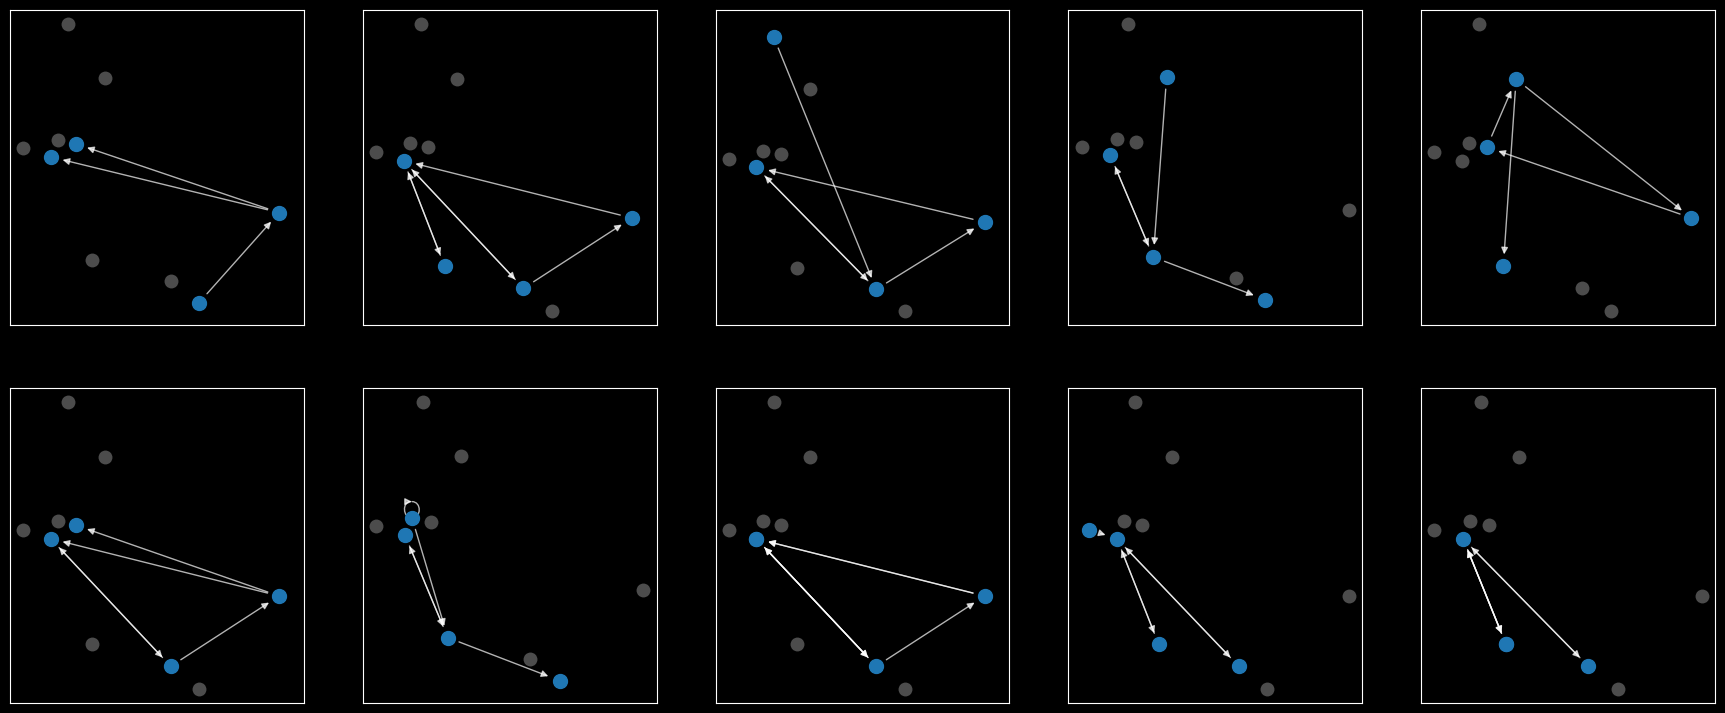

In [ ]:
graphs_list, _ = neighbor_sampler(edges=edges, features=features,
                                  graph_train_mask=None, graph_val_mask=None,
                                  graph_test_mask=None, graph_labels=None,
                                  one_hot_labels=None, seed_nodes=list(range(0,features.shape[0])),
                                  seed_nodes_per_subgraph=1, K1=1, K2=2)

fig, axs = plt.subplots(2, 5, figsize=(22, 9))
axs = axs.flatten()

for i, graph in enumerate(graphs_list):
  A_sample = sp.sparse.csr_array((jnp.ones((graph.senders.shape[0],1)).squeeze(),
                          (graph.senders, graph.receivers)),
                          shape=(graph.nodes.shape[0], graph.nodes.shape[0]))
  G_sample = nx.from_scipy_sparse_array(A_sample, create_using=nx.DiGraph)
  node_pos=graph.nodes
  nx.draw_networkx_nodes(G_sample, pos=node_pos, node_size=100, node_color='#1f77b4', ax = axs[i])
  nx.draw_networkx_edges(G_sample, pos=node_pos, edge_color="white", alpha=0.7, ax=axs[i])
  axs[i].scatter(features[:,0], features[:,1], marker='o', s=100, alpha=0.3, c='white', linewidth=0)

plt.show()

## Test `neighbor_sampler` function with `seed_nodes_per_subgraph=2`

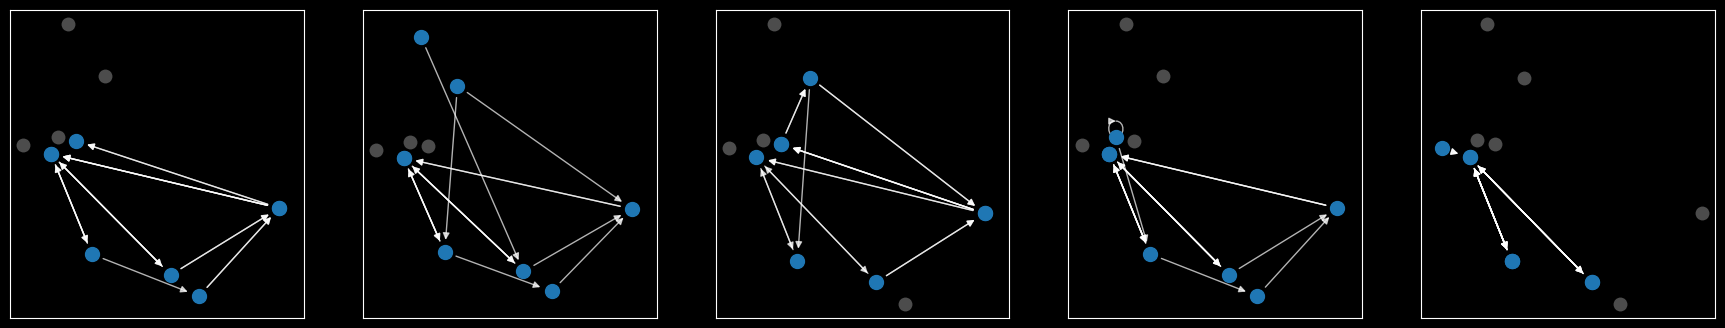

In [ ]:
graphs_list, _ = neighbor_sampler(edges=edges, features=features,
                                  graph_train_mask=None, graph_val_mask=None,
                                  graph_test_mask=None, graph_labels=None,
                                  one_hot_labels=None, seed_nodes=list(range(0,features.shape[0])),
                                  seed_nodes_per_subgraph=2, K1=1, K2=2)
fig, axs = plt.subplots(1, 5, figsize=(22, 4))
axs = axs.flatten()

for i, graph in enumerate(graphs_list):

  A_sample = sp.sparse.csr_array((jnp.ones((graph.senders.shape[0],1)).squeeze(),
                          (graph.senders, graph.receivers)),
                          shape=(graph.nodes.shape[0], graph.nodes.shape[0]))
  G_sample = nx.from_scipy_sparse_array(A_sample, create_using=nx.DiGraph)
  node_pos=graph.nodes
  nx.draw_networkx_nodes(G_sample, pos=node_pos, node_size=100, node_color='#1f77b4', ax = axs[i])
  nx.draw_networkx_edges(G_sample, pos=node_pos, edge_color="white", alpha=0.7, ax=axs[i])
  axs[i].scatter(features[:,0], features[:,1], marker='o', s=100, alpha=0.3, c='white', linewidth=0)

plt.show()

## GraphSAGE vs GraphSAINT

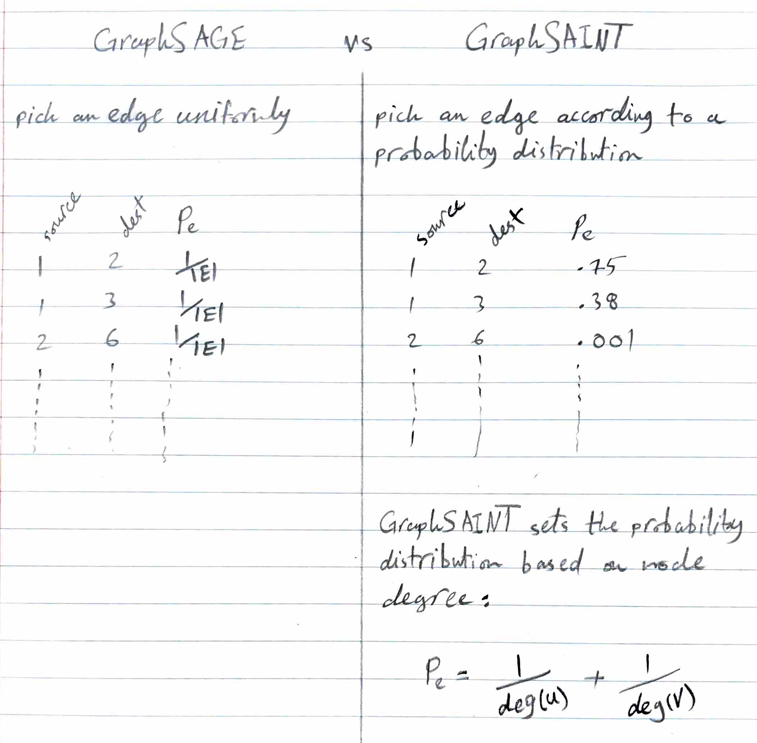

## Import Cora Dataset

In [ ]:
dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())
num_features = dataset.num_features
num_classes = dataset.num_classes
data_Cora = dataset[0]  # Get the first graph object.
data_Cora

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [ ]:
# some statistics about the graph.
print(f'Number of nodes:          {data_Cora.num_nodes}')
print(f'Number of edges:          {data_Cora.num_edges}')
print(f'Average node degree:      {data_Cora.num_edges / data_Cora.num_nodes:.2f}')
print(f'Number of training nodes: {data_Cora.train_mask.sum()}')
print(f'Training node label rate: {int(data_Cora.train_mask.sum()) / data_Cora.num_nodes:.3f}')
print(f'Has isolated nodes:       {data_Cora.has_isolated_nodes()}')
print(f'Has self-loops:           {data_Cora.has_self_loops()}')
print(f'Is undirected:            {data_Cora.is_undirected()}')

Number of nodes:          2708
Number of edges:          10556
Average node degree:      3.90
Number of training nodes: 140
Training node label rate: 0.052
Has isolated nodes:       False
Has self-loops:           False
Is undirected:            True


In [ ]:
graph = jraph.GraphsTuple(
      n_node=jnp.asarray([data_Cora.x.shape[0]]),
      n_edge=jnp.asarray([data_Cora.edge_index.shape[1]]),
      nodes=jnp.asarray(data_Cora.x),
      # No edge features.
      edges=None,
      globals=None,
      senders=jnp.asarray([data_Cora.edge_index[0,:]]).squeeze(),
      receivers=jnp.asarray([data_Cora.edge_index[1,:]]).squeeze())

graph_train_mask = jnp.asarray([data_Cora.train_mask]).squeeze()
graph_val_mask = jnp.asarray([data_Cora.val_mask]).squeeze()
graph_test_mask = jnp.asarray([data_Cora.test_mask]).squeeze()
graph_labels = jnp.asarray([data_Cora.y]).squeeze()
one_hot_labels = jax.nn.one_hot(graph_labels, len(jnp.unique(graph_labels)))

In [ ]:
print(f'Number of nodes: {graph.n_node[0]}')
print(f'Number of edges: {graph.n_edge[0]}')
print(f'Feature matrix data type: {graph.nodes.dtype}')
print(f'senders list data type:   {graph.senders.dtype}')
print(f'receivers list data type: {graph.receivers.dtype}')
print(f'Labels matrix data type:  {graph_labels.dtype}')

Number of nodes: 2708
Number of edges: 10556
Feature matrix data type: float32
senders list data type:   int32
receivers list data type: int32
Labels matrix data type:  int32


## GCN Layers from Jraph

In [ ]:
# Functions must be passed to jraph GNNs, but pytype does not recognise
# linen Modules as callables to here we wrap in a function.
def make_embed_fn(latent_size):
  def embed(inputs):
    return nn.Dense(latent_size)(inputs)
  return embed

def _attention_logit_fn(sender_attr: jnp.ndarray,
                        receiver_attr: jnp.ndarray,
                        edges: jnp.ndarray) -> jnp.ndarray:
  del edges
  x = jnp.concatenate((sender_attr, receiver_attr), axis=1)
  return nn.Dense(1)(x)

In [ ]:
class GCN(nn.Module):
  """Defines a GAT network using FLAX

  Args:
    graph: GraphsTuple the network processes.

  Returns:
    output graph with updated node values.
  """
  gcn1_output_dim: int
  output_dim: int

  @nn.compact
  def __call__(self, x):
    gcn1 = jraph.GraphConvolution(update_node_fn=lambda n: jax.nn.relu(make_embed_fn(self.gcn1_output_dim)(n)),
                          add_self_edges=True)
    gcn2 = jraph.GraphConvolution(update_node_fn=nn.Dense(self.output_dim))
    return gcn2(gcn1(x))

In [ ]:
model = GCN(8, len(jnp.unique(graph_labels)))
model

GCN(
    # attributes
    gcn1_output_dim = 8
    output_dim = 7
)

## Optimizer and Loss
We set the optimizer to adam using `optax` library. Then we initialized the model using random parameters.

In [ ]:
optimizer = optax.adam(learning_rate=0.01)

rng, inp_rng, init_rng = jax.random.split(jax.random.PRNGKey(random_seed), 3)
params = model.init(jax.random.PRNGKey(random_seed),graph)

model_state = train_state.TrainState.create(apply_fn=model.apply,
                                            params=params,
                                            tx=optimizer)

In [ ]:
def compute_loss(state, params, graph, labels, one_hot_labels, mask):
  """Computes loss."""
  pred_graph = state.apply_fn(params, graph)
  preds = jax.nn.log_softmax(pred_graph.nodes)
  loss = optax.softmax_cross_entropy(preds, one_hot_labels)
  loss_mask = jnp.sum(jnp.where(mask, loss, 0)) / jnp.sum(mask)

  pred_labels = jnp.argmax(preds, axis=1)
  acc = (pred_labels == labels)
  acc_mask = jnp.sum(jnp.where(mask, acc, 0)) / jnp.sum(mask)
  return loss_mask, acc_mask

## Training on a full batch

In [ ]:
@jax.jit  # Jit the function for efficiency
def train_step(state, graph, graph_labels, one_hot_labels, train_mask):
  # Gradient function
  grad_fn = jax.value_and_grad(compute_loss,  # Function to calculate the loss
                                argnums=1,  # Parameters are second argument of the function
                                has_aux=True  # Function has additional outputs, here accuracy
                              )
  # Determine gradients for current model, parameters and batch
  (loss, acc), grads = grad_fn(state, state.params, graph, graph_labels, one_hot_labels, train_mask)
  # Perform parameter update with gradients and optimizer
  state = state.apply_gradients(grads=grads)
  # Return state and any other value we might want
  return state, loss, acc

In [ ]:
def train_model(state, graph, graph_labels, one_hot_labels, train_mask, val_mask, num_epochs):
  # Training loop
  for epoch in range(num_epochs):
    state, loss, acc = train_step(state, graph, graph_labels, one_hot_labels, train_mask)
    print(f'step: {epoch:03d}, train loss: {loss:.4f}, train acc: {acc:.4f}')
  return state, acc

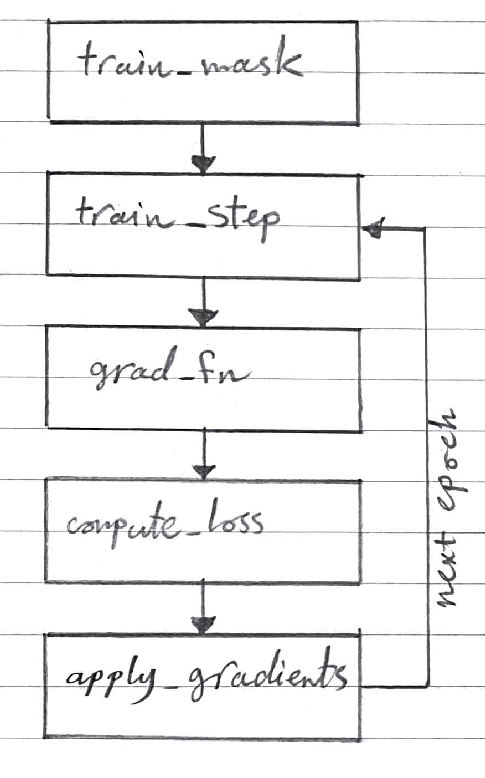

In [ ]:
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))
trained_model_state, train_acc = train_model(model_state, graph, graph_labels, one_hot_labels, graph_train_mask, graph_val_mask, num_epochs=200)
accuracy_list.append(['full batch', 'train', float(train_acc)])

<IPython.core.display.Javascript object>

step: 000, train loss: 1.9460, train acc: 0.1357
step: 001, train loss: 1.9413, train acc: 0.2429
step: 002, train loss: 1.9360, train acc: 0.2786
step: 003, train loss: 1.9289, train acc: 0.2786
step: 004, train loss: 1.9208, train acc: 0.2286
step: 005, train loss: 1.9126, train acc: 0.1786
step: 006, train loss: 1.9045, train acc: 0.1857
step: 007, train loss: 1.8962, train acc: 0.2286
step: 008, train loss: 1.8875, train acc: 0.2786
step: 009, train loss: 1.8783, train acc: 0.2929
step: 010, train loss: 1.8685, train acc: 0.3071
step: 011, train loss: 1.8582, train acc: 0.3357
step: 012, train loss: 1.8474, train acc: 0.3643
step: 013, train loss: 1.8362, train acc: 0.3786
step: 014, train loss: 1.8245, train acc: 0.3786
step: 015, train loss: 1.8123, train acc: 0.3786
step: 016, train loss: 1.7997, train acc: 0.3786
step: 017, train loss: 1.7866, train acc: 0.3786
step: 018, train loss: 1.7729, train acc: 0.3929
step: 019, train loss: 1.7587, train acc: 0.4143
step: 020, train los

In [ ]:
test_loss, test_acc = compute_loss(trained_model_state, trained_model_state.params, graph, graph_labels, one_hot_labels, graph_test_mask)
print(f'test loss: {test_loss:.4f}, test acc: {test_acc:.4f}')
accuracy_list.append(['full batch', 'test', float(test_acc)])

test loss: 0.7673, test acc: 0.7660


## Creating mini batches

In [ ]:
graphs_list, graphinfo_list = neighbor_sampler(edges=jnp.concatenate((jnp.expand_dims(graph.senders,0), jnp.expand_dims(graph.receivers,0)), axis=0).T,
                                               features=graph.nodes,
                                               graph_train_mask=graph_train_mask, graph_val_mask=graph_val_mask,
                                               graph_test_mask=graph_test_mask, graph_labels=graph_labels,
                                               one_hot_labels=one_hot_labels, seed_nodes=list(range(0,data_Cora.x.shape[0])),
                                               seed_nodes_per_subgraph=128, K1=10, K2=25)

In [ ]:
for i, subgraph in enumerate(graphs_list):
  print(f'Subgraph: {i:02d}, feature matrix: {subgraph.nodes.shape}, senders: {subgraph.senders.shape}, receivers: {subgraph.receivers.shape}')

Subgraph: 00, feature matrix: (3587, 1433), senders: (103739,), receivers: (103739,)
Subgraph: 01, feature matrix: (3513, 1433), senders: (88706,), receivers: (88706,)
Subgraph: 02, feature matrix: (4313, 1433), senders: (163630,), receivers: (163630,)
Subgraph: 03, feature matrix: (3692, 1433), senders: (107456,), receivers: (107456,)
Subgraph: 04, feature matrix: (3549, 1433), senders: (90274,), receivers: (90274,)
Subgraph: 05, feature matrix: (4167, 1433), senders: (155466,), receivers: (155466,)
Subgraph: 06, feature matrix: (3807, 1433), senders: (125108,), receivers: (125108,)
Subgraph: 07, feature matrix: (4228, 1433), senders: (137325,), receivers: (137325,)
Subgraph: 08, feature matrix: (4224, 1433), senders: (138434,), receivers: (138434,)
Subgraph: 09, feature matrix: (3905, 1433), senders: (136732,), receivers: (136732,)
Subgraph: 10, feature matrix: (3991, 1433), senders: (147661,), receivers: (147661,)
Subgraph: 11, feature matrix: (3827, 1433), senders: (115281,), recei

## Training on mini batches

In [ ]:
def train_model_batch(state, graphs_list, graphinfo_list, num_epochs):
  # Training loop
  for epoch in range(num_epochs):
    for i, (graph, graphinfo) in enumerate(zip(graphs_list, graphinfo_list)):
      state, loss, acc = train_step(state, graph, graphinfo.y, graphinfo.one_hot_labels, graphinfo.train_mask)

    print(f'step: {epoch:03d}, train loss: {loss:.4f}, train acc: {acc:.4f}')
  return state, acc

In [ ]:
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))
trained_model_state, train_acc = train_model_batch(model_state, graphs_list, graphinfo_list, num_epochs=200)
accuracy_list.append(['mini batch', 'train', float(train_acc)])

<IPython.core.display.Javascript object>

step: 000, train loss: 1.6637, train acc: 0.4921
step: 001, train loss: 1.4275, train acc: 0.4921
step: 002, train loss: 1.2120, train acc: 0.5079
step: 003, train loss: 1.0039, train acc: 0.7619
step: 004, train loss: 0.7902, train acc: 0.8413
step: 005, train loss: 0.5938, train acc: 0.9048
step: 006, train loss: 0.4468, train acc: 0.9048
step: 007, train loss: 0.3485, train acc: 0.9206
step: 008, train loss: 0.2812, train acc: 0.9206
step: 009, train loss: 0.2329, train acc: 0.9683
step: 010, train loss: 0.1975, train acc: 0.9683
step: 011, train loss: 0.1710, train acc: 0.9683
step: 012, train loss: 0.1505, train acc: 0.9683
step: 013, train loss: 0.1342, train acc: 0.9524
step: 014, train loss: 0.1209, train acc: 0.9524
step: 015, train loss: 0.1097, train acc: 0.9524
step: 016, train loss: 0.1004, train acc: 0.9524
step: 017, train loss: 0.0923, train acc: 0.9524
step: 018, train loss: 0.0853, train acc: 0.9524
step: 019, train loss: 0.0792, train acc: 0.9524
step: 020, train los

In [ ]:
test_loss, test_acc = compute_loss(trained_model_state, trained_model_state.params, graph, graph_labels, one_hot_labels, graph_test_mask)
print(f'test loss: {test_loss:.4f}, test acc: {test_acc:.4f}')
accuracy_list.append(['mini batch', 'test', float(test_acc)])

test loss: 1.5532, test acc: 0.7130


## Plotting the results

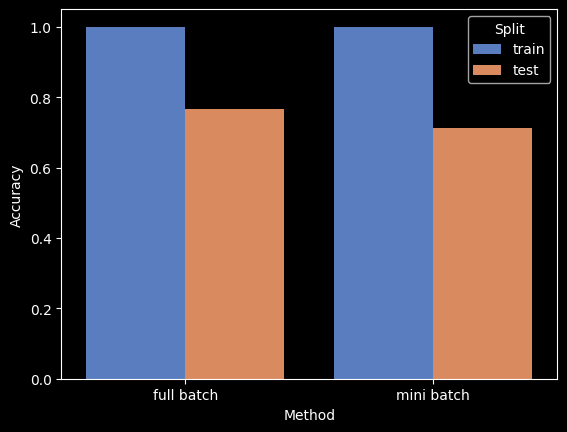

In [ ]:
df = pd.DataFrame(accuracy_list, columns=('Method', 'Split', 'Accuracy'))
sns.barplot(df,x='Method', y='Accuracy', hue='Split', palette="muted")
plt.show()